# Time Series Forecasting

## Setup

In [1]:
import pandas as pd
import keras

import matplotlib.pyplot as plt
import seaborn as sns

2024-06-21 04:19:31.985664: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 04:19:31.987948: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-06-21 04:19:32.020321: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-21 04:19:32.783660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Climate Data Time Series

In [2]:
uri = "https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip"
zip_path = keras.utils.get_file(origin=uri, fname="jena_climate_2009_2016.csv.zip")

13568290/13568290 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
from zipfile import ZipFile

zip_file = ZipFile(zip_path)
zip_file.extractall(path="data/")
csv_path = "data/jena_climate_2009_2016.csv"

df = pd.read_csv(csv_path, usecols=["T (degC)"])

In [4]:
df

,T (degC)
0,-8.02
1,-8.41
2,-8.51
3,-8.31
4,-8.27
...,...
420546,-4.05
420547,-3.35
420548,-3.16
420549,-4.23


## Raw Data Visualization

In [5]:
# sns.lineplot(df)

## Data Preprocessing

Observation is recorded every 10 mins, that means 6 times per hour. We will resample one point per hour since no drastic change is expected within 60 minutes.

In [6]:
NUM_OBSERVATIONS = 2400

In [7]:
smaller_df = df.iloc[-NUM_OBSERVATIONS * 6::6, :].reset_index(drop=True)
smaller_df

,T (degC)
0,13.49
1,13.20
2,12.91
3,13.02
4,12.93
...,...
2395,-0.98
2396,-1.40
2397,-2.75
2398,-2.89


In [8]:
# sns.lineplot(smaller_df)

Since every feature has values with varying ranges, we do normalization to confine feature values to a range of $[0, 1]$ before training a neural network. We do this by subtracting the mean and dividing by the standard deviation of each feature.

In [9]:
def normalize(data):
    data_mean = data.mean(axis=0)
    data_std = data.std(axis=0)
    return (data - data_mean) / data_std

In [10]:
normalized_df = normalize(smaller_df)
normalized_df

,T (degC)
0,1.361937
1,1.310577
2,1.259218
3,1.278699
4,1.262760
...,...
2395,-1.200720
2396,-1.275102
2397,-1.514189
2398,-1.538983


In [11]:
# sns.lineplot(normalized_df)

The goal of the model will be to predict the temperature at the same time of the next day (i.e., 24 time steps in the future) given the past 5 days of data (i.e. 120 time steps).

In [12]:
FUTURE = 24
PAST = 120

In [13]:
import numpy as np

X = np.zeros((NUM_OBSERVATIONS - FUTURE - PAST, PAST))
for i in range(NUM_OBSERVATIONS - FUTURE - PAST):
    X[i, :] = np.array(normalized_df.iloc[i:i + PAST]).squeeze()
X = X.reshape(-1, PAST, 1)

y = np.array(normalized_df.iloc[PAST+FUTURE:]).squeeze()

Leave the last few entries for validation, and use the rest for training.

In [14]:
VAL_SPLIT = 0.1
train_count = int(len(X) * (1 - VAL_SPLIT))

X_train = X[:train_count]
X_val = X[train_count:]

y_train = y[:train_count]
y_val = y[train_count:]

In [15]:
print(X_train.shape)
print(X_val.shape)
print()
print(y_train.shape)
print(y_val.shape)

(2030, 120, 1)
(226, 120, 1)

(2030,)
(226,)


## Standard LSTM Model

### Creating the Model

In [16]:
# model = keras.Sequential(
#     layers = [
#         keras.layers.Input(shape=(PAST, 1)),
#         keras.layers.LSTM(32),
#         keras.layers.Dense(1)
#     ],
#     name="LSTM-Model"
# )
# model.compile(optimizer="adam", loss="mse")
# model.summary()

In [17]:
# es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=25, verbose=1)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
# checkpointer = keras.callbacks.ModelCheckpoint(
#     monitor="val_loss",
#     filepath="models/time-series-forcasting-lstm.keras",
#     verbose=1,
#     save_best_only=True,
# )

In [18]:
# model.fit(
#     X_train,
#     y_train,
#     batch_size=128,
#     shuffle=True,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[reduce_lr, es_callback, checkpointer]
# )

### Model Evaluation

In [19]:
# model_best = keras.models.load_model("models/time-series-forcasting-lstm.keras")

In [20]:
# model_best.evaluate(X_val, y_val)

In [21]:
def show_plot(plot_data, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "go", "rx"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(FUTURE, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (FUTURE + 5) * 2])
    plt.xlabel("Timestep")
    plt.show()
    return

In [22]:
# for x, y in list(zip(X_val, y_val))[10:10+3]:
#     show_plot(
#         [x[:, 0], y, model_best.predict(x.reshape(1, PAST, 1))[0]],
#         "Single Step Prediction",
#     )

## Standard GRU Model

### Creating the Model

In [23]:
# model = keras.Sequential(
#     layers = [
#         keras.layers.Input(shape=(PAST, 1)),
#         keras.layers.GRU(64),
#         keras.layers.Dense(1)
#     ],
#     name="GRU-Model"
# )
# model.compile(optimizer="adam", loss="mse")
# model.summary()

In [24]:
# es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=25, verbose=1)
# reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
# checkpointer = keras.callbacks.ModelCheckpoint(
#     monitor="val_loss",
#     filepath="models/time-series-forcasting-gru.keras",
#     verbose=1,
#     save_best_only=True,
# )

In [25]:
# model.fit(
#     X_train,
#     y_train,
#     batch_size=128,
#     shuffle=True,
#     epochs=100,
#     validation_data=(X_val, y_val),
#     callbacks=[reduce_lr, es_callback, checkpointer]
# )

### Model Evaluation

In [26]:
model_best = keras.models.load_model("models/time-series-forcasting-gru.keras")

In [27]:
model_best.evaluate(X_val, y_val)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1787


0.19374653697013855

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


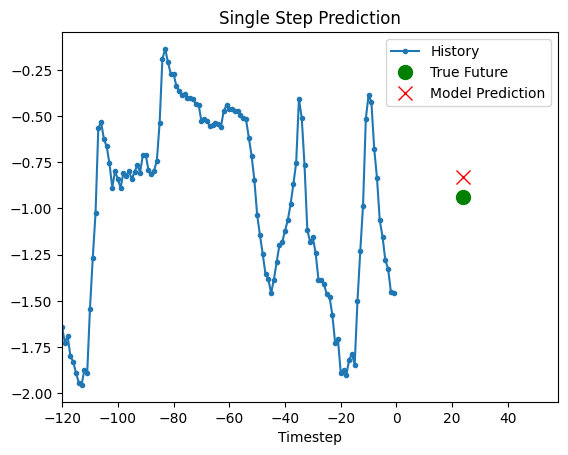

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


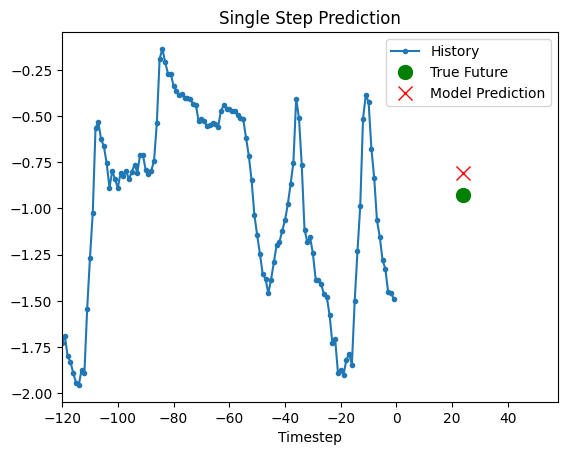

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


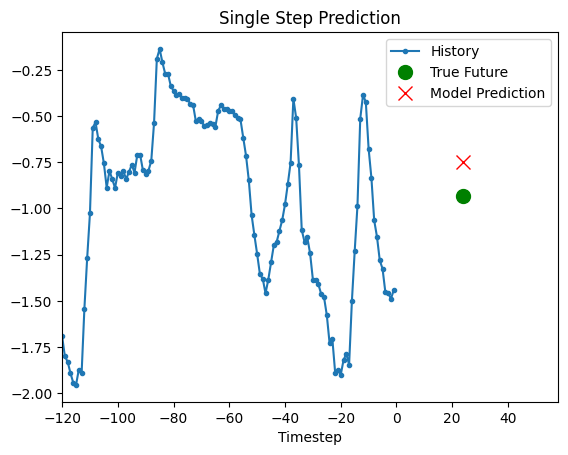

In [28]:
for x, y in list(zip(X_val, y_val))[10:10+3]:
    show_plot(
        [x[:, 0], y, model_best.predict(x.reshape(1, PAST, 1))[0]],
        "Single Step Prediction",
    )

## GRU-MML Model

In [29]:
import keras_mml

In [30]:
model = keras.Sequential(
    layers = [
        keras.layers.Input(shape=(PAST, 1)),
        keras_mml.layers.GRUMML(64),
        keras.layers.Dense(1)
    ],
    name="GRU-Model"
)
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "GRU-Model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ grumml (GRUMML)                 │ (None, 64)             │         4,288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,353 (17.00 KB)

 Trainable params: 4,353 (17.00 KB)

 Non-trainable params: 0 (0.00 B)

In [31]:
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=25, verbose=1)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1)
checkpointer = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath="models/time-series-forcasting-grumml.keras",
    verbose=1,
    save_best_only=True,
)

In [32]:
model.fit(
    X_train,
    y_train,
    batch_size=128,
    shuffle=True,
    epochs=100,
    validation_data=(X_val, y_val),
    callbacks=[reduce_lr, es_callback, checkpointer]
)

Epoch 1/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.9171
Epoch 1: val_loss improved from inf to 0.66811, saving model to models/time-series-forcasting-grumml.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step - loss: 0.9177 - val_loss: 0.6681 - learning_rate: 0.0010
Epoch 2/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 0.9471
Epoch 2: val_loss improved from 0.66811 to 0.65956, saving model to models/time-series-forcasting-grumml.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - loss: 0.9454 - val_loss: 0.6596 - learning_rate: 0.0010
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - loss: 0.8997
Epoch 3: val_loss improved from 0.65956 to 0.63692, saving model to models/time-series-forcasting-grumml.keras
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.8998 - val_loss: 0.6369 - learning_rate: 0.0010
Epoch 4/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 0.8168
Epoch 4: val_loss improved from 0.63692 to 0.61055, saving model to models/time-series-forcasting-grumml.kera

### Model Evaluation

In [33]:
model_best = keras.models.load_model("models/time-series-forcasting-grumml.keras")

In [34]:
model_best.evaluate(X_val, y_val)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.3151 


0.4366243779659271

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step


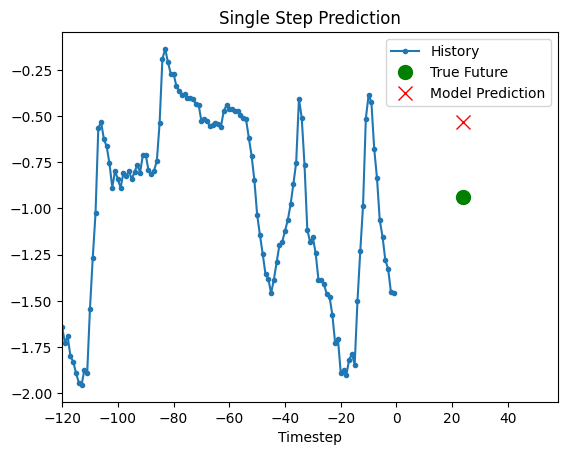

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


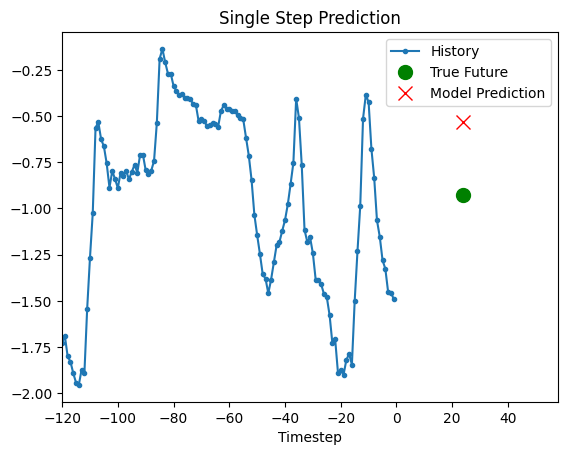

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


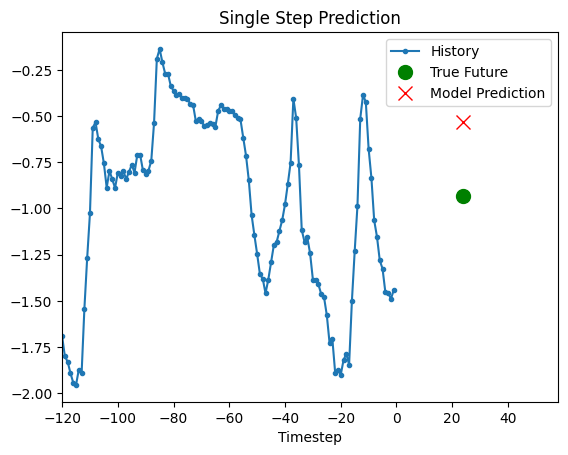

In [35]:
for x, y in list(zip(X_val, y_val))[10:10+3]:
    show_plot(
        [x[:, 0], y, model_best.predict(x.reshape(1, PAST, 1))[0]],
        "Single Step Prediction",
    )